**Drive Mounting**


In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


**Folder Path Set-Up**

In [2]:
import sys
PATH = '/content/gdrive/MyDrive/WiDS/'
sys.path.insert(0,PATH) # Enter path for the WiDS folder on your drive

**Import**

In [3]:
import BallTracking
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import torch
import matplotlib.pyplot as mplt
import torch.nn as nn
import torch.optim as optim
import os

**Model Initialization**

In [4]:
phyModel = BallTracking.PhysicalEulerModel()
plt = BallTracking.Plot()

**Co-ordinate System**

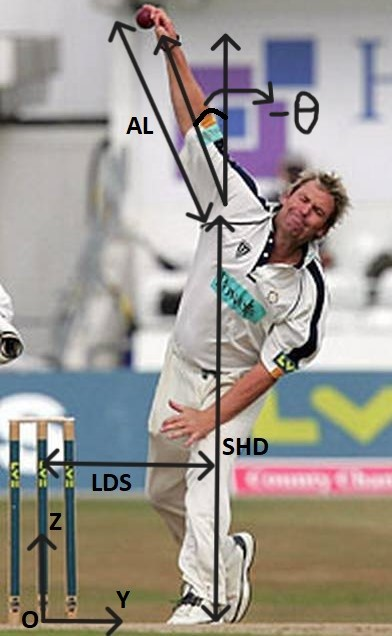

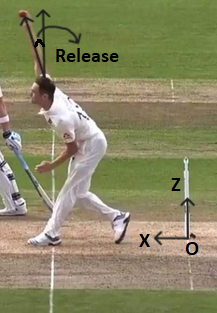

**Visualization**

In [5]:
# Example of a 2d trajectory
speed = 200
release = 7
theta = 15
LDS = 0.1


windspeed = [0.0, 5.0, 0]
bounce = 0.8
SHD = 1.5
AL = 0.6

traj = phyModel.  (speed, release, theta, windspeed, bounce, LDS, SHD, AL, 
                                    history=True, new_ball=True, shallow_transit=False)
plt.plot([traj,traj])

SyntaxError: ignored

*italicized text*# New Section

In [ ]:
# Example of a 3d trajectory
speed = 140
release = 5
theta = 90
windspeed = [0.0, 5.0, 0]
bounce = 0.7
LDS = 0.4
SHD = 1.5
AL = 0.6

traj = phyModel.get_ball_trajectory(speed, release, theta, windspeed, bounce, LDS, SHD, AL, 
                                    history=True, new_ball=True, shallow_transit=False)
plt._plot_3d_trajectory(traj,orientation=90)

In [10]:
class NNModel(nn.Module):
    def __init__(self, input_dim, hidden_dim1,hidden_dim2,hidden_dim3,hidden_dim4,output_dim):
        super(NNModel, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim1 = hidden_dim1
        self.hidden_dim2 = hidden_dim2
        self.hidden_dim3 = hidden_dim3
        self.output_dim = output_dim
        self.input_layer = torch.nn.Linear(input_dim, hidden_dim1)
        self.hidden_layer1 = torch.nn.Linear(hidden_dim1, hidden_dim2)
        self.hidden_layer2 = torch.nn.Linear(hidden_dim2, hidden_dim3)
        self.hidden_layer3 = torch.nn.Linear(hidden_dim3, hidden_dim4)
        self.output_layer = torch.nn.Linear(hidden_dim4, output_dim)
        self.act = torch.nn.ReLU()

    def forward(self, x):
        x = self.input_layer(x)
        x = self.act(x)
        x = self.hidden_layer1(x)
        x = self.act(x)
        x = self.hidden_layer2(x)
        x = self.act(x)
        x = self.hidden_layer3(x)
        # x = self.act(x)
        # x = self.hidden_layer4(x)
        x = self.act(x)  
        x = self.output_layer(x)
        x = torch.sigmoid(x)  # To scale output to [0,1]
        #x = nn.Softmax(x)
        return x

class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))

class LLLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.NLLLoss()
        
    def forward(self,yhat,y):
        return self.mse(yhat,y)

In [7]:
class Bowl(BallTracking.PhysicalEulerModel):
    def __init__(self):
        super(Bowl, self).__init__()
        self.train_losses = []
        self.xs_wicket = torch.tensor([self.L, 0.0, 0.5*self.SH], dtype=torch.float32)
        self.speed_lo, self.speed_hi = 100.0, 160.0
        self.release_lo, self.release_hi = 0.0, 15.0
        self.theta_lo, self.theta_hi = -20.0, 10.0
        self.LDS_lo, self.LDS_hi = 0.5, 1.5
        self.max_windspeed_x = 5.0
        self.max_windspeed_y = 5.0
        self.bounce_lo, self.bounce_spread = 0.7, 0.2
        self.shoulder_hieght_lo, self.shoulder_hieght_spread = 1.4, 0.5
        self.arm_length_lo, self.arm_length_spread = 0.6, 0.2
        self.model_params = {}
        self.cwd = PATH
        self.checkpoint = 0
    
    def set_model_params(self, params):
        self.model_params = params
        self.model = self.model(**self.model_params)
        
    def get_model_params(self):
        return self.model_params
        
    def set_model(self,model="feedforward"):
        models = {"feedforward": NNModel,}
        self.model =  models.get(model.lower())
        
    def get_model(self):
        return self.model
    
    def set_loss_fn(self,loss_fn="rmseloss"):
        loss_fns = {
            "rmseloss": RMSELoss(),
            "mseloss" : nn.MSELoss(),
            "loglikelyloss":LLLoss()
        }
        self.loss_fn =  loss_fns.get(loss_fn.lower())
        
    def get_loss_fn(self):
        return self.loss_fn
    
    def set_optimizer(self,optimizer="adam",learning_rate=1e-4):
        optimizers = {
            "adam" : optim.Adam(self.model.parameters(), lr=learning_rate,weight_decay=1e-7),
            "sgd" : optim.SGD(self.model.parameters(), lr=learning_rate)
        }
        self.optimizer =  optimizers.get(optimizer.lower())
    
    def get_optimizer(self):

        return self.optimizer
    
    def hitting_wicket(self,final_ball_position):
        if (final_ball_position[1] >= -1*self.SW/2 and final_ball_position[1] <= self.SW/2) and (final_ball_position[2] >= 0 and final_ball_position[2] <= self.SH):
            return torch.tensor(1.0)
        else:  
            return torch.tensor(0.0)
        
    def generate_data(self,n_data=1):
        data, data_point = [], []
        self.n_data = n_data
        for i in range(n_data):
            data_point.append((2*np.random.random() - 1)*self.max_windspeed_x)
            data_point.append((2*np.random.random() - 1)*self.max_windspeed_y)
            data_point.append(self.bounce_lo + np.random.random()*self.bounce_spread)
            data_point.append (self.shoulder_hieght_lo + np.random.random()*self.shoulder_hieght_spread)
            data_point.append(self.arm_length_lo + np.random.random()*self.arm_length_spread)
            data_point.append(1.0 if np.random.random() >= 0.3 else -1.0) #bowling_arm
            data_point.append(1.0 if np.random.random() >= 0.3 else -1.0) #bowling_side
            data_point.append(1.0 if np.random.random() >= 0.85 else 0.0) #new_ball
            data_point.append(1.0 if np.random.random() >= 0.30 else 0.0) #shallow_transit
            data.append(data_point)
            data_point = []
        return data
    
    def train_step(self, data, dt):
        self.optimizer.zero_grad()
        input = torch.tensor(data, dtype=torch.float32, requires_grad=True)
        output = self.model(input)

        speed = self.speed_lo + (self.speed_hi - self.speed_lo)*output[0]
        release = self.release_lo + (self.release_hi - self.release_lo)*output[1]
        theta = (self.theta_lo + (self.theta_hi - self.theta_lo)*output[2])*input[5]
        lds = (self.LDS_lo + (self.LDS_hi - self.LDS_lo)* output[3])*input[5]*input[6]
        windspeed = torch.tensor([input[0], input[1], 0.0])
        bounce = input[2]
        shd = input[3]
        al = input[4]

        final_ball_pos, b= self.get_ball_trajectory(speed, release, theta, windspeed, bounce, lds, shd, al, new_ball=input[7], shallow_transit=input[8], dt=dt)
        hit_wicket = self.hitting_wicket(final_ball_pos)
        loss = self.loss_fn(final_ball_pos[1:], self.xs_wicket[1:])*(1 - hit_wicket)

        loss.backward()
        self.optimizer.step()
        return loss.item()

    def train(self,n_iters=10000, plot_steps=100, print_steps=500, dt = 0.005):
        dir_path = os.path.join(self.cwd,"Bowling_Checkpoint")
        if os.path.exists(dir_path):
            pass
        else:
            os.mkdir(dir_path)
        current_loss = 0.0
        for i in range(self.checkpoint,n_iters):
            data = self.generate_data()
            loss = self.train_step(data[0], dt)
            current_loss+=loss
            if (i+1)%plot_steps == 0:
                self.train_losses.append(current_loss/plot_steps)
                current_loss = 0
            if (i+1)%print_steps == 0:
                #print(f"Iter:{i+1}, Completed:{((i+1)/n_iters*100):.0f}%, loss:{loss:.4f}, {self.test_accuracy(50)}")
                print(f"Iter:{i+1}, Completed:{((i+1)/n_iters*100):.0f}%, loss:{loss:.4f}")
                state = {'sample_count': i + 1,
                         'train_losses': self.train_losses,
                         'state_dict': self.model.state_dict(),
                         'optimizer': self.optimizer.state_dict()}
                fpath = os.path.join(dir_path, "checkpoint"+str(i+1)+".pt")
                torch.save(state,fpath)

    def bowl_traj(self, data, dt=0.005):
        n_data = len(data)
        for i in range(n_data):
            with torch.no_grad():
                values = torch.tensor(data[i], dtype=torch.float32, requires_grad=True)
                output = self.model(values)
                speed = self.speed_lo + (self.speed_hi - self.speed_lo)*output[0]
                release = self.release_lo + (self.release_hi - self.release_lo)*output[1]
                theta = (self.theta_lo + (self.theta_hi - self.theta_lo)*output[2])*values[5]
                lds = (self.LDS_lo + (self.LDS_hi - self.LDS_lo)* output[3])*values[5]*values[6]
                interception = 0.75 + (0.95 - 0.75)*np.random.random()
                windspeed = [values[0], values[1], 0.0]
                bounce = values[2]
                shd = values[3]
                al = values[4]

                final_ball_pos, b= self.get_ball_trajectory(speed, release, theta, windspeed, bounce, lds, shd, al, new_ball=values[7], shallow_transit=values[8], dt=dt)
                traj = self.get_ball_trajectory(speed, release, theta, windspeed, bounce, lds, shd, al, new_ball=values[7], shallow_transit=values[8], dt=dt, history=True)
                hit_wicket = self.hitting_wicket(final_ball_pos)
                
                if show_details:
                    print(f'Speed = {speed:.0f} kmph,\t'+f'Release Angle = {release:.2f},\t'+f'Theta = {theta:.2f},\t' +
                          f'Lateral Distance = {abs(lds):.2f} m,\t'+f"Bowling Arm = {'R' if values[5] == 1.0 else 'L'},\t"+f"Ball = {'New' if values[7] else 'Old'},\t")


                traj_len = len(traj)

                interception_idx = int(traj_len*interception)
                intercepted_traj = traj[:interception_idx]
            return traj, intercepted_traj
        
    def test_accuracy(self,n_test,dt=0.005):
        tot_loss = 0
        for i_test in range(n_test):
            input = torch.tensor(self.generate_data()[0], dtype=torch.float32, requires_grad=False)
            output=self.model(input)
            speed = self.speed_lo + (self.speed_hi - self.speed_lo)*output[0]
            release = self.release_lo + (self.release_hi - self.release_lo)*output[1]
            theta = (self.theta_lo + (self.theta_hi - self.theta_lo)*output[2])*input[5]
            lds = (self.LDS_lo + (self.LDS_hi - self.LDS_lo)* output[3])*input[5]*input[6]
            windspeed = torch.tensor([input[0], input[1], 0.0])
            bounce = input[2]
            shd = input[3]
            al = input[4]
            final_ball_pos, b= self.get_ball_trajectory(speed, release, theta, windspeed, bounce, lds, shd, al, new_ball=input[7], shallow_transit=input[8], dt=dt)
            hit_wicket = self.hitting_wicket(final_ball_pos)
            tot_loss = tot_loss+self.loss_fn(final_ball_pos[1:], self.xs_wicket[1:])*(1 - hit_wicket)
        return f"Test loss = {(tot_loss/n_test*100):.2f}"

    # def test_accuracy(self, data, dt=0.005, max_iter=1000, show_details=False, random=False):
    #     accuracy = 0
    #     n_test = len(data)
    #     for i_test in range(n_test):
    #         dp = [data[i_test]]
    #         traj,_ = self.bowl_traj(dp, dt, show_details,random)
    #         accuracy += self.hitting_wicket(traj[-1])
    #     return f"Test accuracy = {(accuracy/n_test*100):.2f}%"

    # def test_accuracy(self,dt=0.005,n_test):
    #     accuracy = 0
    #     for i_test in range(n_test):
    #         input=self.generate_data()
    #         output = self.model(input)
    #         speed = self.speed_lo + (self.speed_hi - self.speed_lo)*output[0]
    #         release = self.release_lo + (self.release_hi - self.release_lo)*output[1]
    #         theta = (self.theta_lo + (self.theta_hi - self.theta_lo)*output[2])*input[5]
    #         lds = (self.LDS_lo + (self.LDS_hi - self.LDS_lo)* output[3])*input[5]*input[6]
    #         windspeed = torch.tensor([input[0], input[1], 0.0])
    #         bounce = input[2]
    #         shd = input[3]
    #         al = input[4]
    #         final_ball_pos, b= self.get_ball_trajectory(speed, release, theta, windspeed, bounce, lds, shd, al, new_ball=input[7], shallow_transit=input[8], dt=dt)
    #         hit_wicket = self.hitting_wicket(final_ball_pos)
    #         accuracy=accuracy+hit_wicket
    #     return f"Test accuracy = {(accuracy/n_test*100):.2f}%"

    # def test_accuracy(self, data, dt=0.005, max_iter=1000, show_details=False, random=False):
    #     accuracy = 0
    #     n_test = len(data)
    #     for i_test in range(n_test):
    #         dp = [data[i_test]]
    #         traj,_ = self.bowl_traj(dp, dt, show_details,random)
    #         accuracy += self.hitting_wicket(traj[-1])
    #     return f"Test accuracy = {(accuracy/n_test*100):.2f}%"

    def load_checkpoint(self,checkpoint):
        dir_path = os.path.join(self.cwd,"Bowling_Checkpoint")
        checkpoint = torch.load(os.path.join(dir_path, "checkpoint"+str(checkpoint)+".pt"))
        self.model.load_state_dict(checkpoint['state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer'])
        self.train_losses = checkpoint['train_losses']
        self.checkpoint = checkpoint['sample_count']
        
    def plot_losses(self):
        mplt.plot(self.train_losses, label="Training loss")
            # plt.plot(self.val_losses, label="Validation loss")
        mplt.legend()
        mplt.title("Losses")
        mplt.show()
        mplt.close()

In [ ]:
bowl = Bowl()
bowl.set_model('feedforward')
bowl.set_model_params({'input_dim': 9,
                        'hidden_dim1': 15,
                        'hidden_dim2': 10,
                        'hidden_dim3': 5,
                        'hidden_dim4': 5,
                        'output_dim': 4})
bowl.set_loss_fn('rmseloss')
bowl.set_optimizer('adam', learning_rate=5e-4)
# bowl.load_checkpoint()
bowl.train(n_iters=12000, plot_steps=10, print_steps=5)
bowl.plot_losses()

Iter:5, Completed:0%, loss:1.2630
Iter:10, Completed:0%, loss:0.5066
Iter:15, Completed:0%, loss:0.4302
Iter:20, Completed:0%, loss:0.4517
Iter:25, Completed:0%, loss:0.8581
Iter:30, Completed:0%, loss:0.6039
Iter:35, Completed:0%, loss:1.0988
Iter:40, Completed:0%, loss:0.5420
Iter:45, Completed:0%, loss:1.2708
Iter:50, Completed:0%, loss:0.9544
Iter:55, Completed:0%, loss:1.2610
Iter:60, Completed:0%, loss:1.2821
Iter:65, Completed:1%, loss:0.6955
Iter:70, Completed:1%, loss:0.4314
Iter:75, Completed:1%, loss:1.2398
Iter:80, Completed:1%, loss:0.3939
Iter:85, Completed:1%, loss:1.2762
Iter:90, Completed:1%, loss:0.3732
Iter:95, Completed:1%, loss:0.4712
Iter:100, Completed:1%, loss:0.8085
Iter:105, Completed:1%, loss:0.5845
Iter:110, Completed:1%, loss:1.3017
Iter:115, Completed:1%, loss:1.2216
Iter:120, Completed:1%, loss:1.2437
Iter:125, Completed:1%, loss:0.4123
Iter:130, Completed:1%, loss:1.0682
Iter:135, Completed:1%, loss:0.5954
Iter:140, Completed:1%, loss:0.4545
Iter:145, Co

In [ ]:
test_data = bowl.generate_data(n_data=1)
for i in [50,100,150,200]:
    bowl.load_checkpoint(i)
    plt.plot(bowl.bowl_traj(test_data,show_details=True))